In [1]:
import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

# Local imports
import tf_data

In [2]:
n = 512
x = np.linspace(0, 1, n)
np.random.seed(100)

degrees = [0, 1, 2]
nknots  = 4
strue = 0.1
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

for degree in degrees:
    bfix = np.random.normal(0, 1, size = nknots + degree)
    data[degree] = tf_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                        signal = "fixed", bfix = bfix, seed = 100, 
                        include_intercept = False)

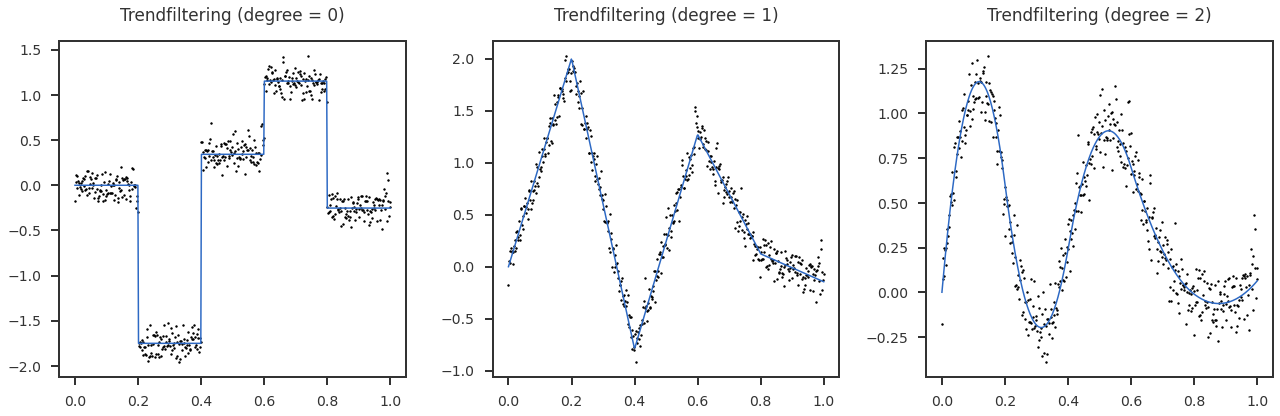

In [3]:
fig = plt.figure(figsize = (18, 6))
for i, d in enumerate(degrees):
    ax = fig.add_subplot(1, 3, i+1)
    ax.scatter(data[d].x, data[d].y, s = 2, color = 'black')
    ax.plot(data[d].x, data[d].ytrue)
    ax.set_title(f"Trendfiltering (degree = {d})", pad = 20)
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
fig.show()

In [4]:
from gradvi.models import basis_matrix
from gradvi.inference import WaveletRegression
from gradvi.inference import LinearRegression
from gradvi.tests import toy_priors


dk = 0
dv = data[dk]
H = basis_matrix.trendfiltering_scaled(n, dk)
Hinv = basis_matrix.trendfiltering_inverse_scaled(n, dk)

prior_init = toy_priors.get_ash(k = 10, sparsity = 0.9, skbase = (dk + 1) * 2)
gv1 = LinearRegression(optimize_s = False, maxiter = 2000, fit_intercept = False, obj = 'direct', tol = 1e-7)
gv1.fit(H, dv.y, prior_init, s2_init = 0.001)

2022-05-03 20:09:13,477 | gradvi.inference.linear_regression | INFO | Terminated at iteration 2000.


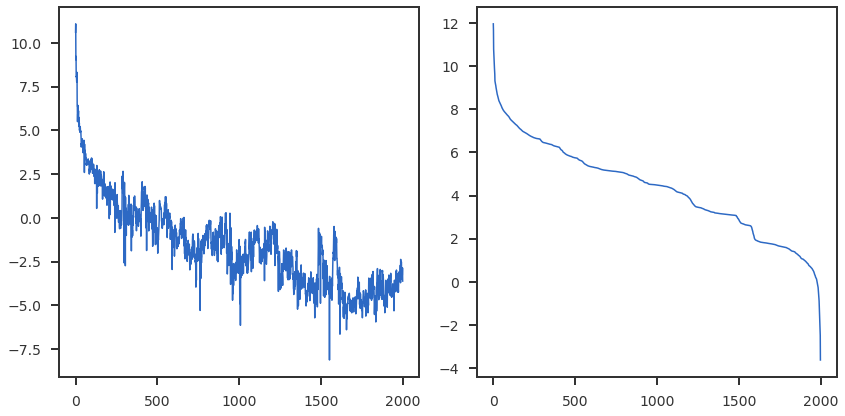

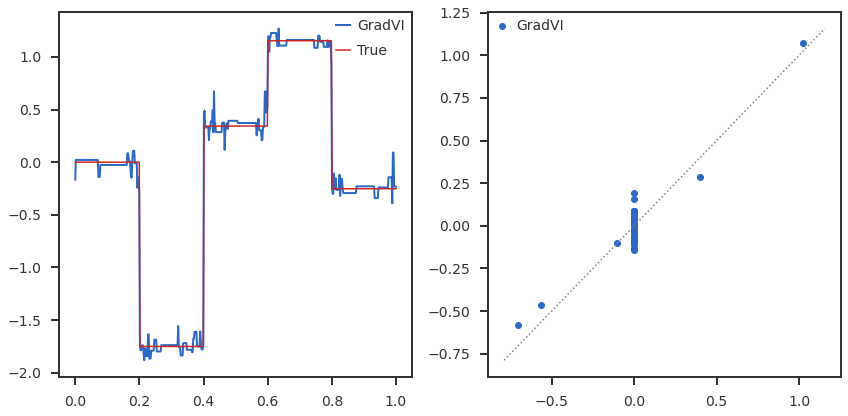

In [5]:
fig = plt.figure(figsize = (12, 6))

log_objdiff = np.log(-np.diff(gv1.obj_path))
log_objpath = np.log(gv1.obj_path[:gv1.niter - 1] - gv1.obj_path[gv1.niter-1])

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(np.arange(gv1.niter - 1), log_objdiff)
ax2.plot(np.arange(gv1.niter - 1), log_objpath)

fig.tight_layout()
fig.show()

fig = plt.figure(figsize = (12, 6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#ax1.scatter(dv.x, dv.y, s = 2, color = 'grey')
ax1.plot(dv.x, np.dot(H, gv1.coef), lw = 2, label = 'GradVI')
ax1.plot(dv.x, dv.ytrue, label = 'True')

ax2.scatter(dv.btrue, gv1.coef, label = 'GradVI')
mpl_utils.plot_diag(ax2)

ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [6]:
s2_init = np.var(dv.y - np.dot(H, gv1.coef))
print(s2_init)

prior = toy_priors.get_ash_scaled(k = 10, sparsity = 0.9, skbase = (dk + 1) * 30)
gv2 = LinearRegression(maxiter = 10000, obj = 'reparametrize', tol = 1e-8)
gv2.fit(H, dv.y, prior, b_init = gv1.coef, s2_init = s2_init)

0.0067387007214962
2022-05-03 20:09:42,170 | gradvi.inference.linear_regression | INFO | Terminated at iteration 1017.


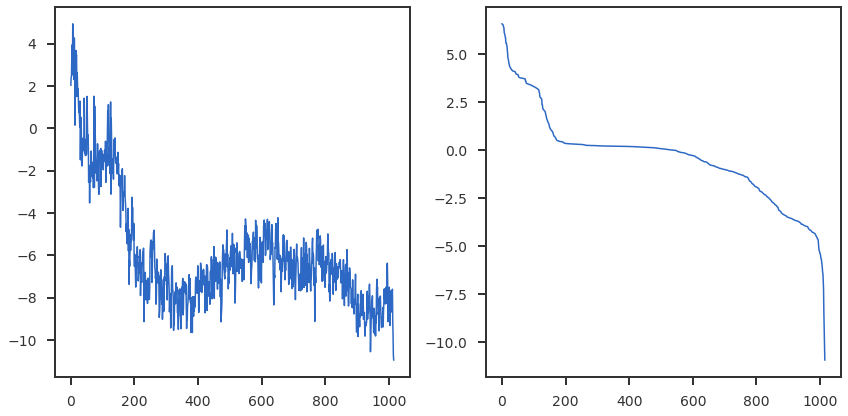

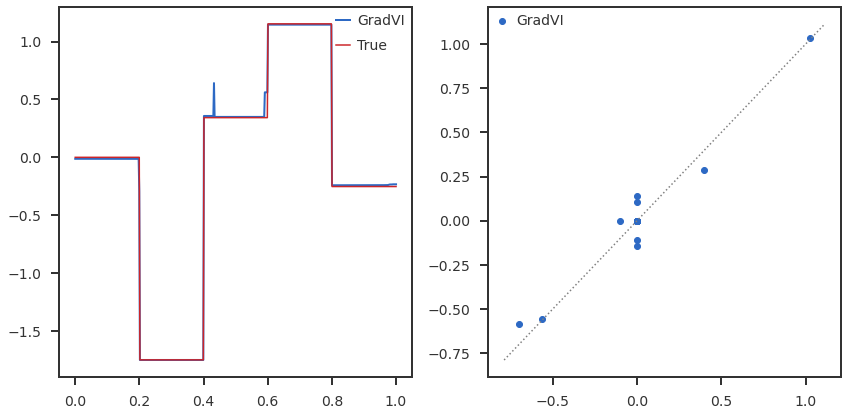

In [7]:
fig = plt.figure(figsize = (12, 6))

log_objdiff = np.log(-np.diff(gv2.obj_path))
log_objpath = np.log(gv2.obj_path[:gv2.niter - 1] - gv2.obj_path[gv2.niter-1])

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(np.arange(gv2.niter - 1), log_objdiff)
ax2.plot(np.arange(gv2.niter - 1), log_objpath)

fig.tight_layout()
fig.show()

fig = plt.figure(figsize = (12, 6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
#ax1.scatter(dv.x, dv.y, s = 2, color = 'grey')
ax1.plot(dv.x, np.dot(H, gv2.coef) + gv2.intercept, lw = 2, label = 'GradVI')
ax1.plot(dv.x, dv.ytrue, label = 'True')

ax2.scatter(dv.btrue, gv2.coef, label = 'GradVI')
#ax2.scatter(dv.btrue, res['genlasso'][dk].coef, label = 'GenLasso')
mpl_utils.plot_diag(ax2)

ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()